## Jax Implementation of Test LSWT:
#### Or How I Learned to Stop Worrying and Love the Jacobian

Tobias's succinct implementation of LSWT

In [1]:
#
# minimalistic implementation of linear spin-wave theory (see: https://arxiv.org/abs/1402.6069)
# @author Tobias Weber <tweber@ill.fr>
# @date 24-oct-2024
# @license see 'LICENSE' file
# @see https://github.com/ILLGrenoble/magpie for full implementation and references
#
import numpy as np, numpy.linalg as la


# debug output
verbose_print = False    # print intermediate results
def print_infos(str):
	if verbose_print:
		print(str)


# calculate magnetic structure properties
def init(sites, couplings, verbose = False):
	global verbose_print
	verbose_print = verbose

	# skew-symmetric (cross-product) matrix
	def skew(v):
		return np.array([[ 0., v[2], -v[1] ], [ -v[2], 0., v[0] ], [ v[1], -v[0], 0. ] ])
	
	# calculate spin rotations towards ferromagnetic order along [001]
	for site in sites:
		zdir = np.array([ 0., 0., 1. ])
		Sdir = np.array(site["Sdir"]) / la.norm(site["Sdir"])
		rotaxis = np.array([ 0., 1., 0. ])
		s = 0.

		if np.allclose(Sdir, zdir):
			c = 1.    # spin and z axis parallel
		elif np.allclose(Sdir, -zdir):
			c = -1.   # spin and z axis anti-parallel
		else:
			# sine and cosine of the angle between spin and z axis
			rotaxis = np.cross(Sdir, zdir)
			s = la.norm(rotaxis)
			c = np.dot(Sdir, zdir)
			rotaxis /= s

		# rotation via rodrigues' formula, see (Arens 2015), p. 718 and p. 816
		rot = (1. - c) * np.outer(rotaxis, rotaxis) + np.diag([ c, c, c ]) - skew(rotaxis)*s
		site["u"] = rot[0, :] + 1j * rot[1, :]
		site["v"] = rot[2, :]
		print_infos("\nrot = \n%s\nu = %s\nv = %s" % (rot, site["u"], site["v"]))

	for coupling in couplings:
		coupling["J_real"] = np.diag([ coupling["J"] ]*3) + skew(coupling["DMI"]) + coupling["gen"]
		print_infos("\nJ_real =\n%s" % coupling["J_real"])


# get the energies of the dispersion at the momentum transfer Qvec
def get_energies(Qvec, sites, couplings):
	num_sites = len(sites)
	J_fourier = np.zeros((num_sites, num_sites, 3, 3), dtype = complex)
	J0_fourier = np.zeros((num_sites, num_sites, 3, 3), dtype = complex)

	for coupling in couplings:
		dist = np.array(coupling["dist"])
		J_real = coupling["J_real"]
		site1, site2 = coupling["sites"]

		J_ft = J_real * np.exp(-1j * 2.*np.pi * np.dot(dist, Qvec))
		J_fourier[site1, site2] += J_ft
		J_fourier[site2, site1] += J_ft.transpose().conj()
		J0_fourier[site1, site2] += J_real
		J0_fourier[site2, site1] += J_real.transpose().conj()
	print_infos("\n\nQ = %s\nJ_fourier =\n%s\n\nJ0_fourier =\n%s" % (Qvec, J_fourier, J0_fourier))

	H = np.zeros((2*num_sites, 2*num_sites), dtype = complex)
	for i in range(num_sites):
		S_i, u_i, v_i = sites[i]["S"], sites[i]["u"], sites[i]["v"]

		for j in range(num_sites):
			S_j, u_j, v_j = sites[j]["S"], sites[j]["u"], sites[j]["v"]
			S = 0.5 * np.sqrt(S_i * S_j)

			H[i, j] += S * np.dot(u_i, np.dot(J_fourier[i, j], u_j.conj()))
			H[i, i] -= S_j * np.dot(v_i, np.dot(J0_fourier[i, j], v_j))
			H[num_sites + i, num_sites + j] += S * np.dot(u_i.conj(), np.dot(J_fourier[i, j], u_j))
			H[num_sites + i, num_sites + i] -= S_j * np.dot(v_i, np.dot(J0_fourier[i, j], v_j))
			H[i, num_sites + j] += S * np.dot(u_i, np.dot(J_fourier[i, j], u_j))
			H[num_sites + i, j] += (S * np.dot(u_j, np.dot(J_fourier[j, i], u_i))).conj()

	C = la.cholesky(H)
	signs = np.diag(np.concatenate((np.repeat(1, num_sites), np.repeat(-1, num_sites))))
	H_trafo = np.dot(C.transpose().conj(), np.dot(signs, C))

	Es = np.real(la.eigvals(H_trafo))
	print_infos("\nH =\n%s\nC =\n%s\nH_trafo =\n%s\nEs = %s" % (H, C, H_trafo, Es))
	return Es



#!/usr/bin/env python3
#
# demo calculating a ferromagnetic dispersion with DMI,
# test for the minimalistic implementation of linear spin-wave theory (see: https://arxiv.org/abs/1402.6069)
#
# @author Tobias Weber <tweber@ill.fr>
# @date 9-feb-2026
# @license see 'LICENSE' file
# @see https://github.com/ILLGrenoble/magpie for full implementation and references
#

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt


num_Q_points = 1024   # number of Q points to calculate
only_pos_E   = False  # hide magnon annihilation?
verbose      = False  # debug output

# interaction constants
J   = -1
DMI = [ 0., 0., 0.6 ]
SIA = -0.2


#
# set up magnetic sites and couplings:
#
#   - magnetic sites:
#     "S": spin magnitude
#     "Sdir": spin direction
#
#   - magnetic couplings:
#     "sites": indices of the sites to couple
#     "J": (symmetric) exchange interaction
#     "DMI": (antisymmetric) Dzyaloshinskii-Moryia interaction
#     "gen": arbitrary interaction matrix, can be used for single-ion anisotropy
#     "dist": distance in rlu to the next unit cell for the coupling
#
sites = [
	{ "S" : 1., "Sdir" : [ 0, 0, 1 ] },
]

# add a small SIA term to shift the energies
sia = np.zeros([3, 3])
sia[2, 2] = SIA

couplings = [
	# J, DMI, and SIA interactions
	{ "sites" : [ 0, 0 ], "J" : J, "DMI" : DMI, "gen" : sia, "dist" : [ 1, 0, 0 ] },
]

print("Calculating non-reciprocal ferromagnetic dispersion...")
init(sites, couplings, verbose)

# plot a dispersion branch
hs = []
Es = []
for h in np.linspace(-1, 1, num_Q_points):
	try:
		Qvec = np.array([ h, 0, 0 ])
		for E in get_energies(Qvec, sites, couplings):
			if only_pos_E and E < 0.:
				continue
			hs.append(h)
			Es.append(E)
	except la.LinAlgError:
		pass
hs_original, Es_original = hs.copy(), Es.copy()


# plt.plot()
# plt.xlabel("h (rlu)")
# plt.ylabel("E (meV)")
# plt.scatter(hs, Es, marker = '.', label = "Ferromagnetic, Non-Reciprocal")

# print("Plotting...")
# plt.legend(loc = "upper right")
# plt.tight_layout()
# plt.show()

Calculating non-reciprocal ferromagnetic dispersion...


The output of this model:

Plotting...


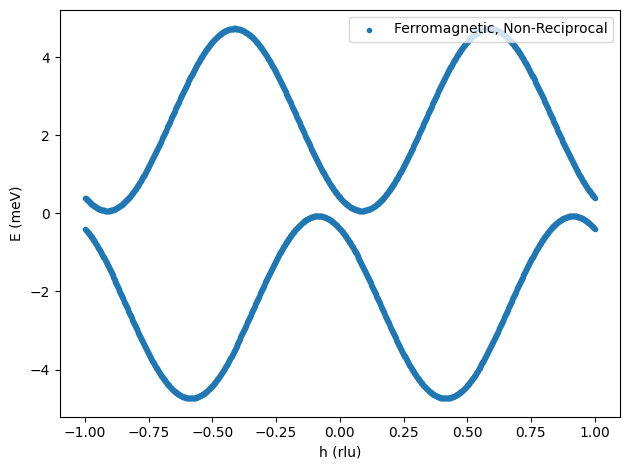

In [2]:
plt.plot()
plt.xlabel("h (rlu)")
plt.ylabel("E (meV)")
plt.scatter(hs, Es, marker = '.', label = "Ferromagnetic, Non-Reciprocal")

print("Plotting...")
plt.legend(loc = "upper right")
plt.tight_layout()
plt.show()

Implementing in Jax.

Things that don't work well in Jax:
* in-place modifications
* conditionals
* debugging
* arbitrary data structures (e.g. dicts)

Thngs jax can do well:
* vectorization
* calculating gradients

To get this code working with jax, I got rid of the dictionary based approach because this is not compatible with autodiff

In [3]:
import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
import jax.numpy.linalg as jla
from jax import vmap
import numpy as np

# -----------------------------------------------------------------------------
# helpers
# -----------------------------------------------------------------------------

def skew(v):
    """Skew-symmetric cross-product matrix"""
    return jnp.array([
        [0.0,    v[2], -v[1]],
        [-v[2],  0.0,   v[0]],
        [v[1],  -v[0],  0.0]
    ])

# -----------------------------------------------------------------------------
# Jax rotation computation
# -----------------------------------------------------------------------------

def compute_rotation_vectorized(Sdir):
    """Vectorized rotation computation for a single site direction."""
    zdir = jnp.array([0.0, 0.0, 1.0])
    Sdir_norm = Sdir / jla.norm(Sdir)
    
    # Check special cases
    cond1 = jnp.all(jnp.isclose(Sdir_norm, zdir, atol=1e-10))
    cond2 = jnp.all(jnp.isclose(Sdir_norm, -zdir, atol=1e-10))
    
    # General case rotation
    rotaxis = jnp.cross(Sdir_norm, zdir)
    s = jla.norm(rotaxis)
    c = jnp.dot(Sdir_norm, zdir)
    
    # Avoid division by zero
    rotaxis_safe = rotaxis / (s + 1e-12)
    
    # Rodrigues' rotation formula
    K = skew(rotaxis_safe)
    rot = jnp.eye(3) + s * K + (1 - c) * (jnp.outer(rotaxis_safe, rotaxis_safe) - jnp.eye(3))
    
    # Handle special cases
    rot = jnp.where(cond1, jnp.eye(3), rot)
    rot = jnp.where(cond2, jnp.diag(jnp.array([1.0, 1.0, -1.0])), rot)
    
    u = rot[0, :] + 1j * rot[1, :]
    v = rot[2, :]
    return u, v, rot

# Vectorize over sites
compute_rotation_batch = vmap(compute_rotation_vectorized, in_axes=(0,))

def init_structure(S_values, S_directions, couplings_data, verbose=False):
    """
    Jax initialization of magnetic structure.
    """
    num_sites = len(S_values)
    
    # Compute rotations for all sites
    u_vectors, v_vectors, _ = compute_rotation_batch(S_directions)
    
    # Unpack couplings data
    sites_i, sites_j, J_values, DMI_vectors, gen_matrices, dist_vectors = couplings_data
    num_couplings = len(sites_i)
    
    # Vectorized construction of J_real matrices
    J_diag = jnp.eye(3)[None, :, :] * J_values[:, None, None]
    DMI_skew = vmap(skew)(DMI_vectors)
    J_real_matrices = J_diag + DMI_skew + gen_matrices
    
    if verbose:
        print(f"u_vectors shape: {u_vectors.shape}")
        print(f"v_vectors shape: {v_vectors.shape}")
        print(f"J_real_matrices shape: {J_real_matrices.shape}")
    
    return S_values, u_vectors, v_vectors, (sites_i, sites_j, J_real_matrices, dist_vectors)

# -----------------------------------------------------------------------------
# Jax dispersion calculation
# -----------------------------------------------------------------------------
@jax.jit
def compute_energies_for_Q(Qvec, S_values, u_vectors, v_vectors, couplings_data):
    """
    Jax computation for a single Q vector.
    """
    num_sites = len(S_values)
    sites_i, sites_j, J_real_matrices, dist_vectors = couplings_data
    
    # Compute Fourier phases for all couplings
    phases = jnp.exp(-1j * 2.0 * jnp.pi * jnp.dot(dist_vectors, Qvec))
    J_ft = J_real_matrices * phases[:, None, None]
    
    # Initialize matrices
    J_fourier = jnp.zeros((num_sites, num_sites, 3, 3), dtype=jnp.complex128)
    J0_fourier = jnp.zeros((num_sites, num_sites, 3, 3), dtype=jnp.complex128)
    
    # Scatter updates (efficient in JAX)
    J_fourier = J_fourier.at[sites_i, sites_j].add(J_ft)
    J_fourier = J_fourier.at[sites_j, sites_i].add(jnp.conj(jnp.transpose(J_ft, (0, 2, 1))))
    
    J0_fourier = J0_fourier.at[sites_i, sites_j].add(J_real_matrices)
    J0_fourier = J0_fourier.at[sites_j, sites_i].add(jnp.transpose(J_real_matrices, (0, 2, 1)))
    
    # Precompute S_sqrt matrix efficiently
    S_sqrt = 0.5 * jnp.sqrt(S_values[:, None] * S_values[None, :])
    
    # Compute Hamiltonian blocks using einsum (replaces nested loops)
    
    # H_AA = S_sqrt * (u_i · J_ij · u_j*)
    # We need to compute for all i,j pairs
    u_expanded_i = u_vectors[:, None, :]  # [num_sites, 1, 3]
    u_expanded_j = u_vectors[None, :, :]  # [1, num_sites, 3]
    
    # Compute u_i · J_ij for all i,j
    u_dot_J = jnp.einsum('iak,ijkl->ijl', u_expanded_i, J_fourier)
    
    # Compute u_i · J_ij · u_j*
    H_AA = jnp.einsum('ijl,jl->ij', u_dot_J, u_vectors.conj()) * S_sqrt
    
    # H_BB = S_sqrt * (u_i* · J_ij · u_j)
    u_conj_dot_J = jnp.einsum('iak,ijkl->ijl', u_expanded_i.conj(), J_fourier)
    H_BB = jnp.einsum('ijl,jl->ij', u_conj_dot_J, u_vectors) * S_sqrt
    
    # H_AB = S_sqrt * (u_i · J_ij · u_j)
    H_AB = jnp.einsum('ijl,jl->ij', u_dot_J, u_vectors) * S_sqrt
    
    # Add diagonal terms efficiently
    # diag_term_i = -Σ_j S_j * (v_i · J0_ij · v_j)
    v_expanded_i = v_vectors[:, None, :]  # [num_sites, 1, 3]
    v_dot_J0 = jnp.einsum('iak,ijkl->ijl', v_expanded_i, J0_fourier)
    diag_terms = -jnp.einsum('ijl,jl->i', v_dot_J0, v_vectors) * S_values
    
    # Add to diagonal of H_AA and H_BB
    diag_indices = jnp.diag_indices(num_sites)
    H_AA = H_AA.at[diag_indices].add(diag_terms)
    H_BB = H_BB.at[diag_indices].add(diag_terms)
    
    # Construct full Hamiltonian
    H_top = jnp.concatenate([H_AA, H_AB], axis=1)
    H_bottom = jnp.concatenate([jnp.conj(H_AB.T), H_BB], axis=1)
    H = jnp.concatenate([H_top, H_bottom], axis=0)
    
    # Solve generalized eigenvalue problem efficiently
    sigma_z = jnp.diag(jnp.concatenate([jnp.ones(num_sites), -jnp.ones(num_sites)]))
    H_eff = sigma_z @ H
    
    # Use eigh for Hermitian matrices (faster and ensures real eigenvalues)
    Es, _ = jla.eigh(H_eff)
    
    return jnp.sort(Es)

# Vectorized version for multiple Q points
compute_energies_for_Q_batch= jax.jit(vmap(
    compute_energies_for_Q, 
    in_axes=(0, None, None, None, None)
))

Now I wrap up all the function call into a single function that depends only on J, DMI, and SIA. Any other parameters can also be included here, I use these as examples of parameters of interest

In [4]:
@jax.jit
def calc_dispersion_curve(Q_points, J_DMI_SIA):
    J, DMI, SIA = J_DMI_SIA
    num_Q_points = len(Q_points) # 1024
    DMI = jnp.array([0.0, 0.0, DMI])

    # Site data as arrays
    S_values = jnp.array([1.0])
    S_directions = jnp.array([[0.0, 0.0, 1.0]])
    
    # Coupling data as arrays
    sites_i = jnp.array([0], dtype=jnp.int32)
    sites_j = jnp.array([0], dtype=jnp.int32)
    J_values = jnp.array([J, ]).reshape(1)
    DMI_vectors = jnp.array([DMI])
    
    sia = jnp.zeros((1, 3, 3))
    sia = sia.at[0, 2, 2].set(SIA)
    
    gen_matrices = sia
    dist_vectors = jnp.array([[1.0, 0.0, 0.0]])
    
    couplings_data = (sites_i, sites_j, J_values, DMI_vectors, gen_matrices, dist_vectors)
    
    # Initialize structure
    S_values, u_vectors, v_vectors, couplings_data_final = init_structure(
        S_values, S_directions, couplings_data, verbose=False
    )
    
    # Create Q points
    # Q_points = jnp.linspace(-1, 1, num_Q_points)
    Q_vecs = jnp.stack([Q_points, jnp.zeros(num_Q_points), jnp.zeros(num_Q_points)], axis=1)
    
    print("Calculating non-reciprocal ferromagnetic dispersion (JAX with vmap)...")
    
    # Compute all energies at once using vmap
    all_Es = compute_energies_for_Q_batch(Q_vecs, S_values, u_vectors, v_vectors, couplings_data_final)
    
    return all_Es

Calculating non-reciprocal ferromagnetic dispersion (JAX with vmap)...


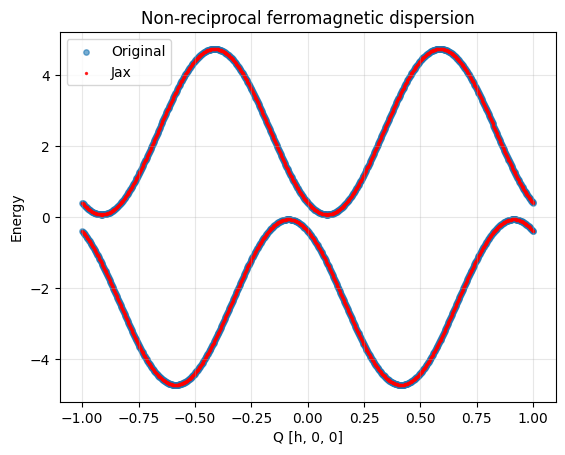

In [5]:
q_range = jnp.linspace(-1, 1, num_Q_points)
q_batch = q_range[None].repeat(2, 0).T
Es_jax = calc_dispersion_curve(q_range, jnp.array([-1., 0.6, -0.2]))    

Es_original = jnp.asarray(Es_original)
plt.scatter(hs_original, Es_original, s=15, alpha=0.6, label='Original')
plt.scatter(q_batch, Es_jax, s=2, alpha=0.8, label='Jax', color='red')
plt.xlabel("Q [h, 0, 0]")
plt.ylabel("Energy")
plt.title("Non-reciprocal ferromagnetic dispersion")
plt.grid(True, alpha=0.3)
plt.legend()

Now for the secret sauce: jacobians

In [6]:
params = jnp.array([-1., 0.6, -0.2])
Es = calc_dispersion_curve(q_range, params)
J = jax.jacobian(calc_dispersion_curve, argnums=1)(q_range, params)

I am going to use the "Delta Method" to take 1st order propagation of uncertainties through the dispersion curve.

Link here: https://en.wikipedia.org/wiki/Delta_method

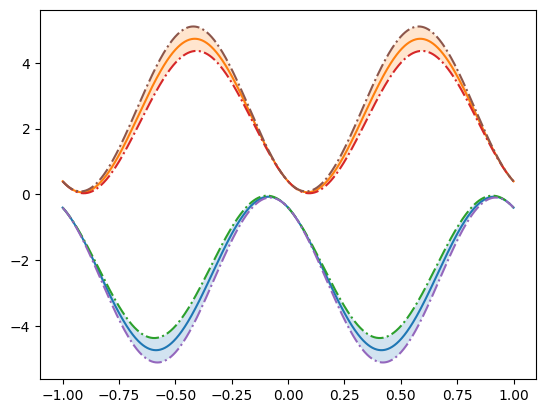

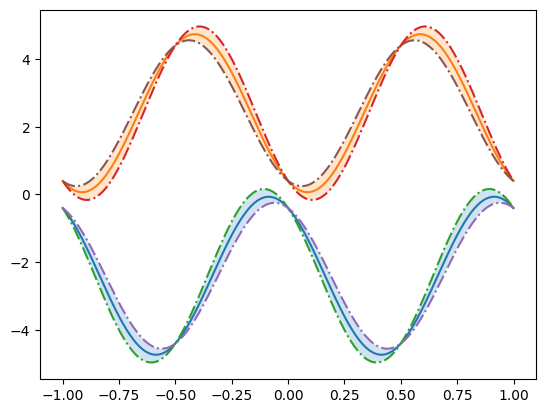

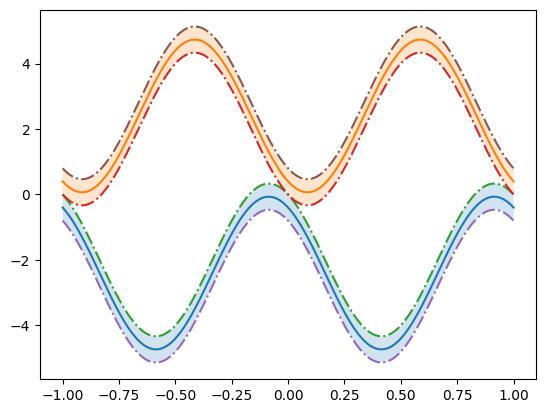

In [7]:
for param_stds in [[0.1, 0.0, 0.0], [0, 0.2, 0], [0, 0, 0.2]]:
    param_stds = jnp.array(param_stds)

    cov = jnp.diag(param_stds**2)
    var = jax.vmap(jax.vmap(lambda j: j @ cov @ j.T))(J)
    std = jnp.sqrt(var)
    for E, s in zip(Es.T, std.T):
        plt.plot(q_range, E)
        plt.fill_between(q_range, E-s, E+s, alpha=0.2)

    _e = calc_dispersion_curve(q_range, params+param_stds)
    for _ in _e.T:
        plt.plot(q_range, _, linestyle='-.')
    _e = calc_dispersion_curve(q_range, params-param_stds)
    for _ in _e.T:
        plt.plot(q_range, _, linestyle='-.')
    plt.show()

Now that we can visualize how the outputs disagree, we need one other piece for design of experiments: how the system responds to measurement (spectral weights)

There is a theorem "Bayesian Active Learning by Disagreement" that is worth a read

For a primer on experimental design, I recommend the thesis of Adam Foster from Oxford in Statistics

In [8]:
spectral_weight_func = lambda q, p: 3 + 10 * (jnp.abs(calc_dispersion_curve(q, p)) * jnp.sin(q[...,None])**2)
gamma = 0.5
intensity_func = lambda q, e, p: (spectral_weight_func(q, p) * gamma**2 / (jnp.pi * (gamma**2 + (e[...,None]-calc_dispersion_curve(q, p))**2))).sum(1)

In [9]:
spectral_weights =  spectral_weight_func(q_range, params)

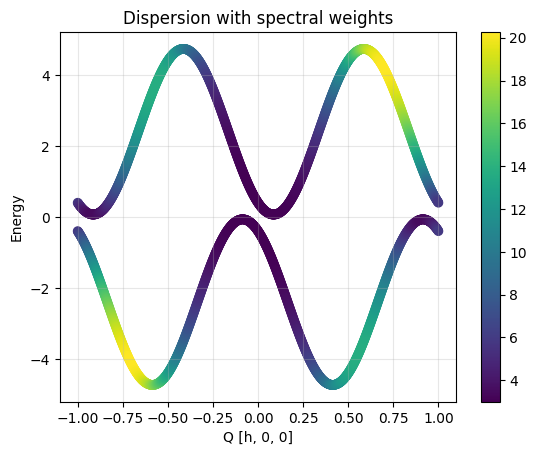

In [10]:
plt.scatter(q_batch, Es_jax, c=spectral_weights)
plt.colorbar()
plt.xlabel("Q [h, 0, 0]")
plt.ylabel("Energy")
plt.title("Dispersion with spectral weights")
plt.grid(True, alpha=0.3)

Now calculating:

EIG = expectation(H\[current\] - H\[future\]) 

For fisher information of poisson count, count time comes in as a linear factor, so maybe we make the assumption that a curve can be measured 2x as easily if the peak is 4x higher

In [11]:
cov = jnp.array([
    [0.02, 0.0, 0.0],
    [0.0, 0.5, 0.0],
    [0.0, 0.0, 0.01],
])
print(jnp.linalg.slogdet(cov))

SlogdetResult(sign=Array(1., dtype=float64), logabsdet=Array(-9.21034037, dtype=float64))


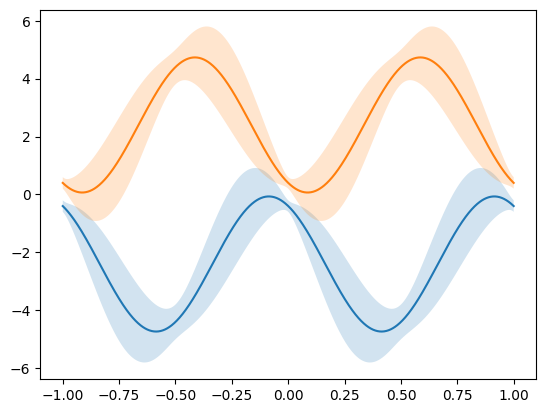

In [12]:
J = jax.jacobian(calc_dispersion_curve, 1)(q_range, params)
var = jax.vmap(jax.vmap(lambda j: j @ cov @ j.T))(J)
std = jnp.sqrt(var)
for E, s in zip(Es.T, std.T):
    plt.plot(q_range, E)
    plt.fill_between(q_range, E-s, E+s, alpha=0.2)

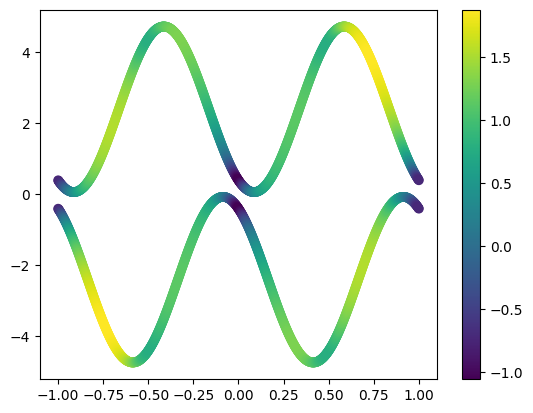

In [13]:
EIG = 0.5 * jnp.log(spectral_weights * var)
plt.scatter(q_batch, Es_jax, c=EIG)
plt.colorbar()

We can also assume that the model is a sum-of-lorentzians and compute the EIG this way

In [14]:
X = jnp.array([[_q, _e] for _q in jnp.linspace(-1,1,35) for _e in jnp.linspace(-6,6,31)])

Calculating non-reciprocal ferromagnetic dispersion (JAX with vmap)...


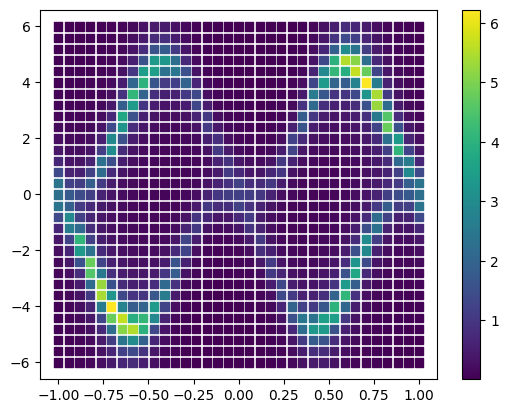

In [15]:
# intensity = w * gamma**2 / (jnp.pi * (gamma**2 + (X[:,1,None]-dispersion)**2))
# intensity = intensity.sum(1)
intensity = intensity_func(*X.T, params)
# plt.scatter(q_batch, Es_jax, c=spectral_weights)
plt.scatter(*X.T, c=intensity, marker='s')
plt.colorbar()

In [16]:
J = jax.jacobian(intensity_func, argnums=2)(*X.T, params)
EIG = 0.5 * jnp.linalg.slogdet(jnp.eye(len(params)) + cov @ jnp.einsum('np,n,nq->npq', J, 1/intensity, J))[1]
EIG.shape

(1085,)

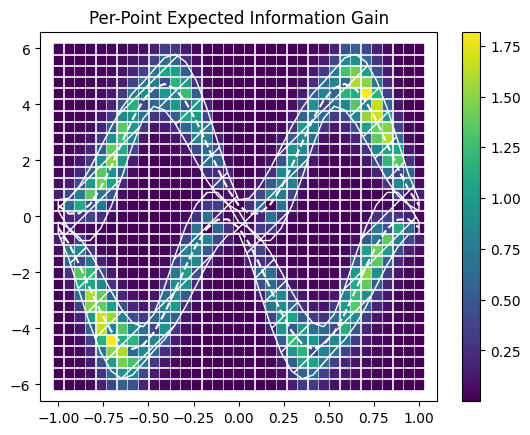

In [17]:
plt.scatter(*X.T, c=EIG, marker='s')
plt.title('Per-Point Expected Information Gain')
var = jax.vmap(jax.vmap(lambda j: j @ cov @ j.T))(jax.jacobian(calc_dispersion_curve, 1)(X[:,0], params))
std = jnp.sqrt(var)
disp = calc_dispersion_curve(X[:,0], params)
plt.plot(X[:,0,None].repeat(2,-1), disp, c='white', linestyle='--', )
for d,s in zip(disp.T,std.T):
    plt.fill_between(X[:,0], d-s, d+s, color='white', hatch='/', alpha=1., facecolor='none')
plt.colorbar()

We can see that the top right is the most appealing region because both intensity and uncertainty are high. the q=0 region has little uncertainty and little amplitude